In [1]:
%matplotlib inline
import numpy as np
import lib.io.stan
import lib.plots.stan
import matplotlib.pyplot as plt
import os
from matplotlib.lines import Line2D
import retro_prepare
import matplotlib.colors

In [2]:
hpf = 10
lpf = 0.05

patient_id = 'id017_mk'
szr_name = "MK_crise1Part1_170328C-BEX_0004_MK_crise1Part2_170328C-BEX_0007"

'''
patient_id = 'id001_bt'
szr_name = 'BTcrise2appportable_0013'

patient_id = 'id003_mg'
szr_name = 'MGcrise1'

patient_id = 'id004_bj'
szr_name = 'BJcrise1le161128B-BEX_0002'

patient_id = 'id010_cmn'
szr_name = 'CMN_crise4P_140320B-DEX_0008'

patient_id = 'id020_lma'
szr_name = 'LM_crise3P_100415b-bex_0005'

patient_id = 'id025_mc'
szr_name = 'MC_C1_Part1_080429ccex_0002_MC_C1_Part2_080429ccex_0003'

patient_id = 'id050_sx'
szr_name = 'SX_C4P_111202C-EEX_0002'


patient_id = 'id022_te'
szr_name = 'TE_crise2P_130306C-BEX_0000'


patient_id = 'id027_sj'
szr_name = 'SJ_crise1PSG_120214D-CEX_0003'


patient_id = 'id030_bf'
szr_name = 'BF_crise1P_110831B-CEX_0004'

patient_id = 'id039_mra'
szr_name = 'MR_C4P_170124b-cex_0028'


patient_id = 'id013_lk'
szr_name = 'LK_crise1P_160707A-AEX_0013'


patient_id = 'id014_vc'
szr_name = 'VC_crise2P_131127C-EEX_0002'

'''

data_dir = f'datasets/retro/{patient_id}'
results_dir = f'results/exp10/exp10.68/{patient_id}'
meta_data_fname = f'{szr_name}.json'

fname_suffix = f'{szr_name}_hpf{hpf}_lpf{lpf}'

In [3]:
data=lib.io.stan.rload(f'{results_dir}/Rfiles/fit_data_{fname_suffix}.R')
raw_seeg_fname = f'{szr_name}.raw.fif'
seeg, bip = retro_prepare.read_one_seeg(data_dir, meta_data_fname, raw_seeg_fname)

Isotrak not found


In [4]:
def read_vep_mrtrix_lut():
    roi_names = []
    with open('./data/VepMrtrixLut.txt', 'r') as fd:
        for line in fd.readlines():
            i, roi_name, *_ = line.strip().split()
            roi_names.append(roi_name)
            #roi_name_to_index[roi_name.lower()] = int(i) - 1
    return roi_names
roi = read_vep_mrtrix_lut()
roi=roi[1:]


In [5]:
import json
with open(f'./data/ei-vep.json','r') as f:
    ezh_all = json.load(f)
ind_ez = ezh_all[patient_id]['i_ez']
ind_pz = ezh_all[patient_id]['i_pz']

In [6]:
def VEP_D(optima, onst_thrshld=0.0):
    x = optima['x'].mean(axis=0)
    nn = x.shape[1]
    onsets = 200*np.ones(nn)
    for i in range(nn):
        xt = x[:,i] > onst_thrshld
        if(xt.any()):
            onsets[i] = np.where(x[:,i] > onst_thrshld)[0][0]
    a, b = np.histogram(onsets[onsets<150])
    ez_pred = np.zeros(nn)
    ez_pred[np.where(onsets<b[2])] = 1
    return ez_pred

def VEP_C(optima, onst_thrshld=0.0):
    x = optima['x'].mean(axis=0)
    nn = x.shape[1]
    onsets = 200*np.ones(nn)
    for indnn in range(nn):
        xt = x[:,indnn] > onst_thrshld
        if(xt.any()):
            onsets[indnn] = np.where(x[:,indnn] > onst_thrshld)[0][0]
    ez_pred = -np.log((onsets+1)/(200+1))
    return ez_pred

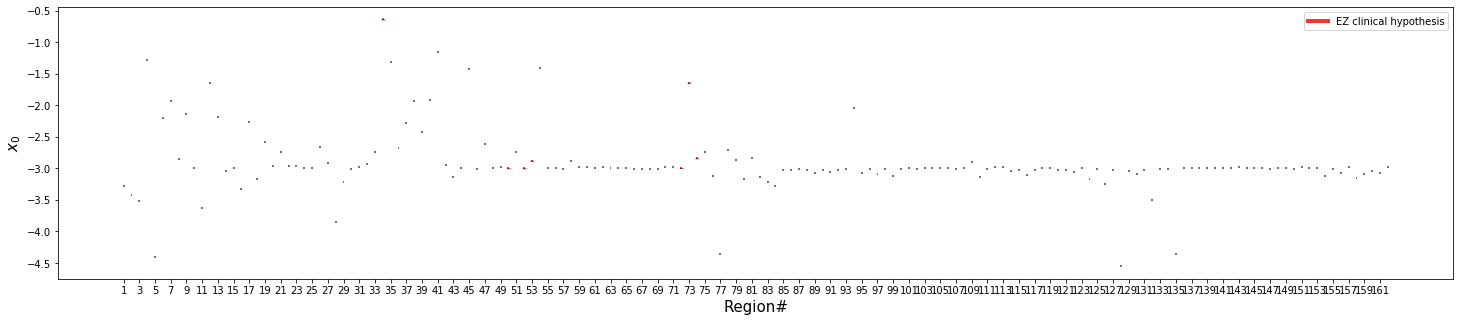

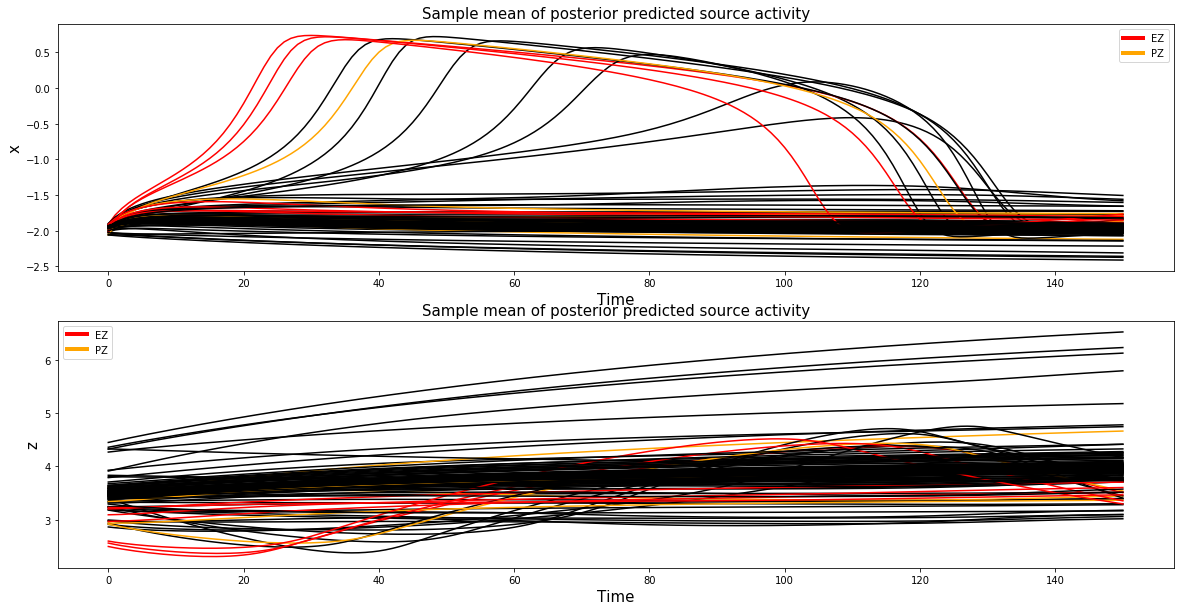

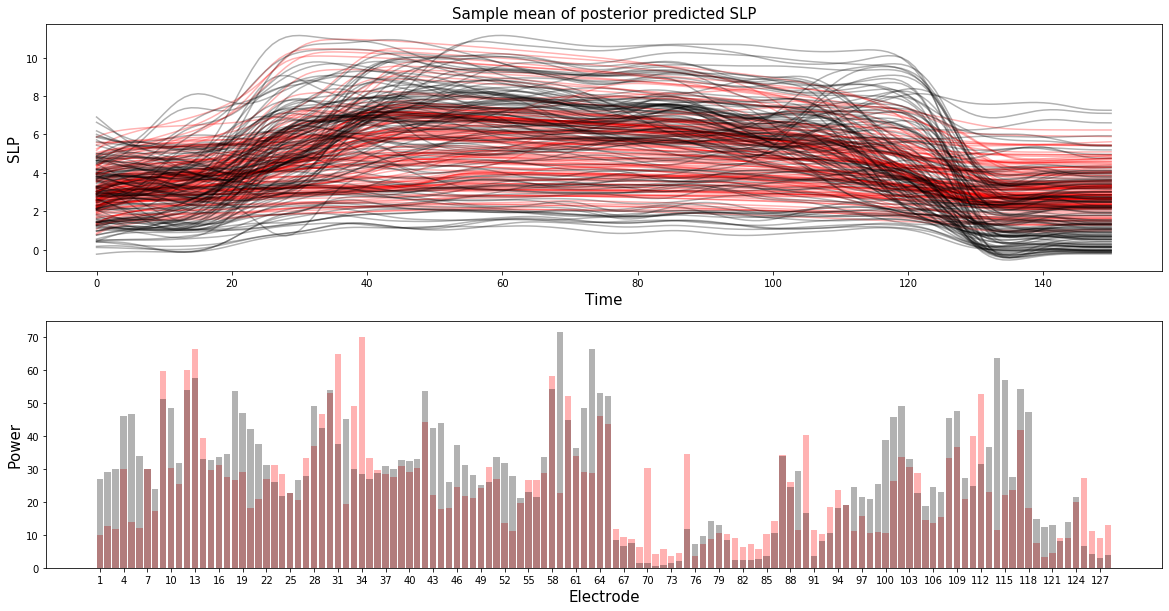

In [7]:
pstr_samples = lib.io.stan.read_samples([f'{results_dir}/optima/samples_{fname_suffix}.csv'])
lib.plots.stan.x0_violin_patient(pstr_samples['x0'], ind_ez, figsize=(25,5), figname=f'{results_dir}/figures/x0_violin_{fname_suffix}.png')
lib.plots.stan.plot_source(pstr_samples['x'].mean(axis=0), pstr_samples['z'].mean(axis=0), ind_ez, ind_pz,
                           figname=f'{results_dir}/figures/posterior_predicted_src_{fname_suffix}.png')
lib.plots.stan.plot_fit_target({'slp':pstr_samples['mu_slp'].mean(axis=0), 'snsr_pwr':pstr_samples['mu_snsr_pwr'].mean(axis=0)},
                               data, figname=f'{results_dir}/figures/posterior_predicted_slp_{fname_suffix}.png')

In [8]:
ei_data = np.load(os.path.join(results_dir, 'ei_data.npz'))
VEP_A = np.zeros(data['nn'])
VEP_A[ei_data['ez_idcs']] = 1.0

In [9]:
csv_path = f'{results_dir}/optima/samples_{fname_suffix}.csv'
#csv_path = f'{results_dir}/OptimalBT/samples_fit_data_{fname_suffix}_hpf10_lpf0.05_ezdelay_{ii}.csv'
optima = lib.io.stan.read_samples([csv_path])
x0_infer = optima['x0']
VEP_B = x0_infer
onst_thrshld=0.0

ez_pred_vep_c = VEP_C(optima, onst_thrshld=0.0)
VEP_C = ez_pred_vep_c

ez_pred_vep_d = VEP_D(optima, onst_thrshld=0.0)
VEP_D = ez_pred_vep_d

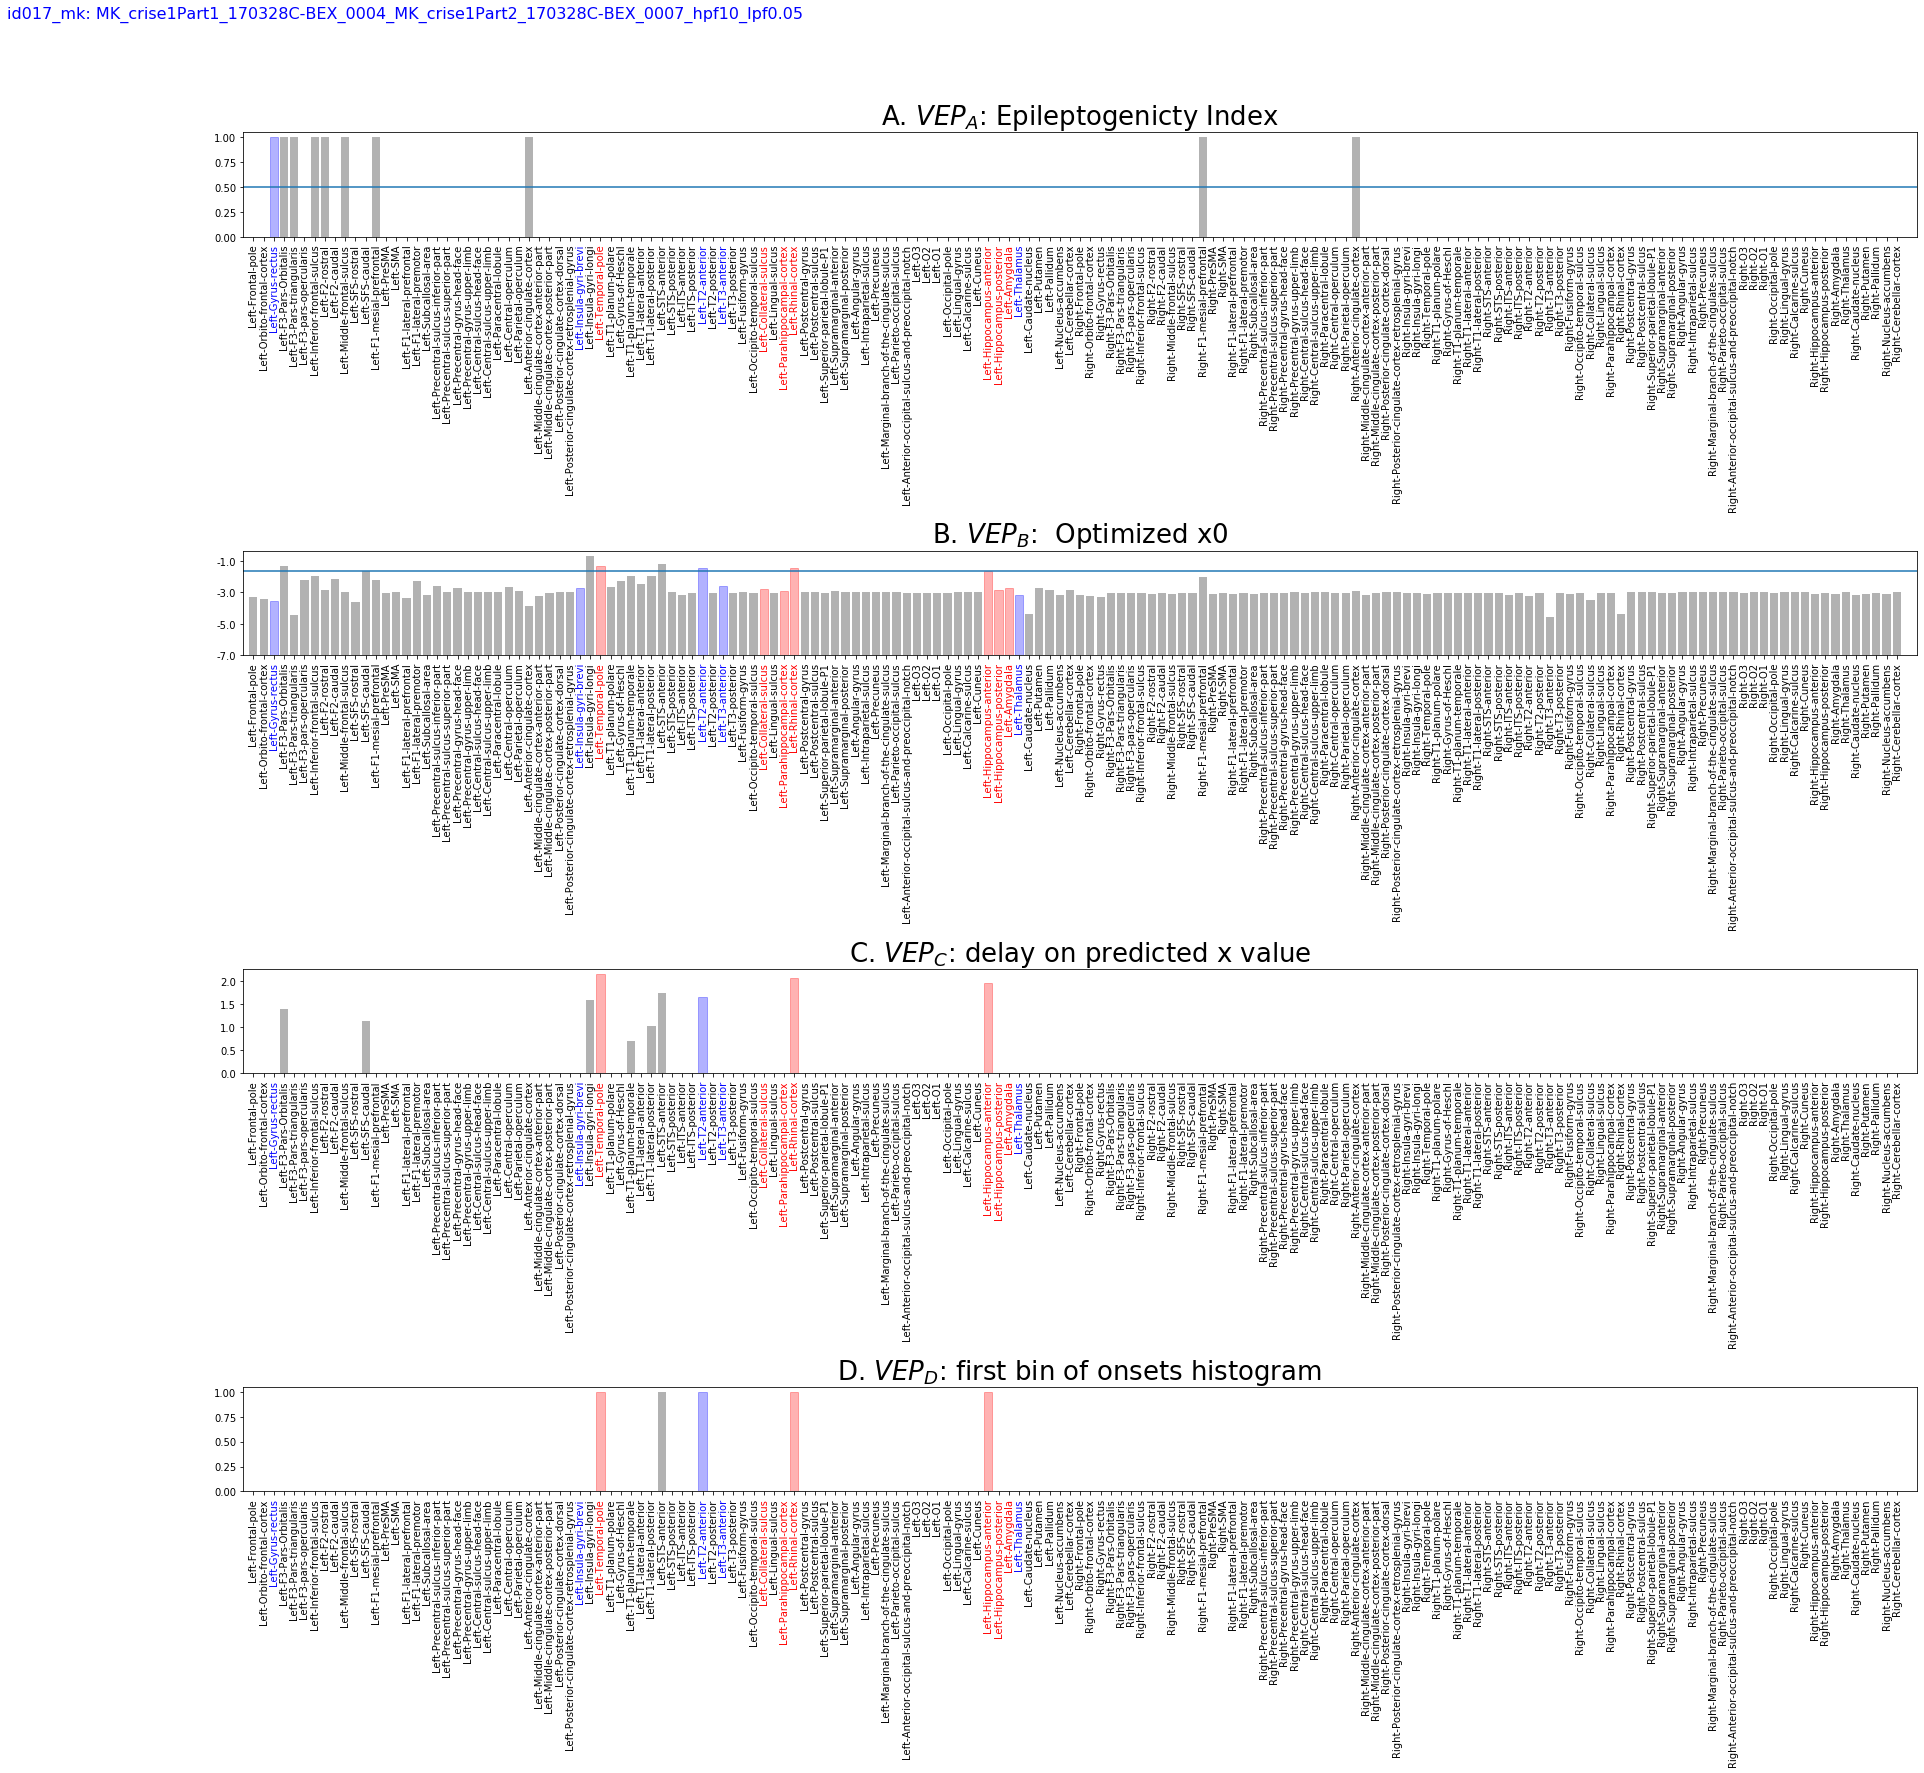

In [10]:
# Plot one 

import matplotlib.gridspec as gridspec
pstr_samples = lib.io.stan.read_samples([f'{results_dir}/optima/samples_{fname_suffix}.csv'])
figsize = [30,25]
x0_infer = pstr_samples['x0']
ns = x0_infer.shape[1]
plt.figure(figsize=figsize)
gs = gridspec.GridSpec(4,1,hspace = 3)
#ax = plt.subplot(3,1,2)


#plt.figure(figsize=figsize)
#gs = gridspec.GridSpec(1,2,width_ratios = [1,8])

#ax = plt.subplot(3,1,1)
ax=plt.subplot(gs[0,0])
barlist=plt.bar(np.arange(0, ns), VEP_A, color='black', alpha=0.3)
plt.xticks(np.r_[:len(roi)], roi, rotation = 90);

for ichanvep in ezh_all[patient_id]['i_ez']:
    plt.gca().get_xticklabels()[ichanvep].set_color('red')
    barlist[ichanvep].set_color('r')
for ichanvep in ezh_all[patient_id]['i_pz']:
    plt.gca().get_xticklabels()[ichanvep].set_color('blue')
    barlist[ichanvep].set_color('blue')
plt.title('A. $VEP_A$: Epileptogenicty Index', fontsize = 26);
ax.axhline(0.5)
plt.xlim([-1,163])

ax=plt.subplot(gs[1,0])
barlist=plt.bar(np.arange(0, ns), x0_infer[0]+7, color='black', alpha=0.3)
plt.xticks(np.r_[:len(roi)], roi, rotation = 90);
ax.axhline(-1.6+7)
for ichanvep in ezh_all[patient_id]['i_ez']:
    plt.gca().get_xticklabels()[ichanvep].set_color('red')
    barlist[ichanvep].set_color('r')
for ichanvep in ezh_all[patient_id]['i_pz']:
    plt.gca().get_xticklabels()[ichanvep].set_color('blue')
    barlist[ichanvep].set_color('blue')
plt.title('B. $VEP_B$:  Optimized x0', fontsize = 26)       
plt.xlim([-1,163])
ax.set_yticklabels(item-7. for item in ax.get_yticks())


ax=plt.subplot(gs[2,0])
#ax = plt.subplot(3,1,3)
#plt.figure(figsize=figsize)
barlist=plt.bar(np.arange(0, ns), VEP_C, color='black', alpha=0.3)
plt.xticks(np.r_[:len(roi)], roi, rotation = 90);

for ichanvep in ezh_all[patient_id]['i_ez']:
    plt.gca().get_xticklabels()[ichanvep].set_color('red')
    barlist[ichanvep].set_color('r')
for ichanvep in ezh_all[patient_id]['i_pz']:
    plt.gca().get_xticklabels()[ichanvep].set_color('blue')
    barlist[ichanvep].set_color('blue')
plt.title('C. $VEP_C$: delay on predicted x value', fontsize = 26);
plt.xlim([-1,163])

ax=plt.subplot(gs[3,0])
barlist=plt.bar(np.arange(0, ns), VEP_D, color='black', alpha=0.3)
plt.xticks(np.r_[:len(roi)], roi, rotation = 90);

for ichanvep in ezh_all[patient_id]['i_ez']:
    plt.gca().get_xticklabels()[ichanvep].set_color('red')
    barlist[ichanvep].set_color('r')
for ichanvep in ezh_all[patient_id]['i_pz']:
    plt.gca().get_xticklabels()[ichanvep].set_color('blue')
    barlist[ichanvep].set_color('blue')
plt.title('D. $VEP_D$: first bin of onsets histogram ', fontsize = 26);
plt.xlim([-1,163])

figname=f'{results_dir}/figures/Vep3value_{fname_suffix}.png'
plt.suptitle(f'{patient_id}: {fname_suffix}',x=0.2, y=.95, fontsize = 16, color='blue')
plt.savefig(figname)

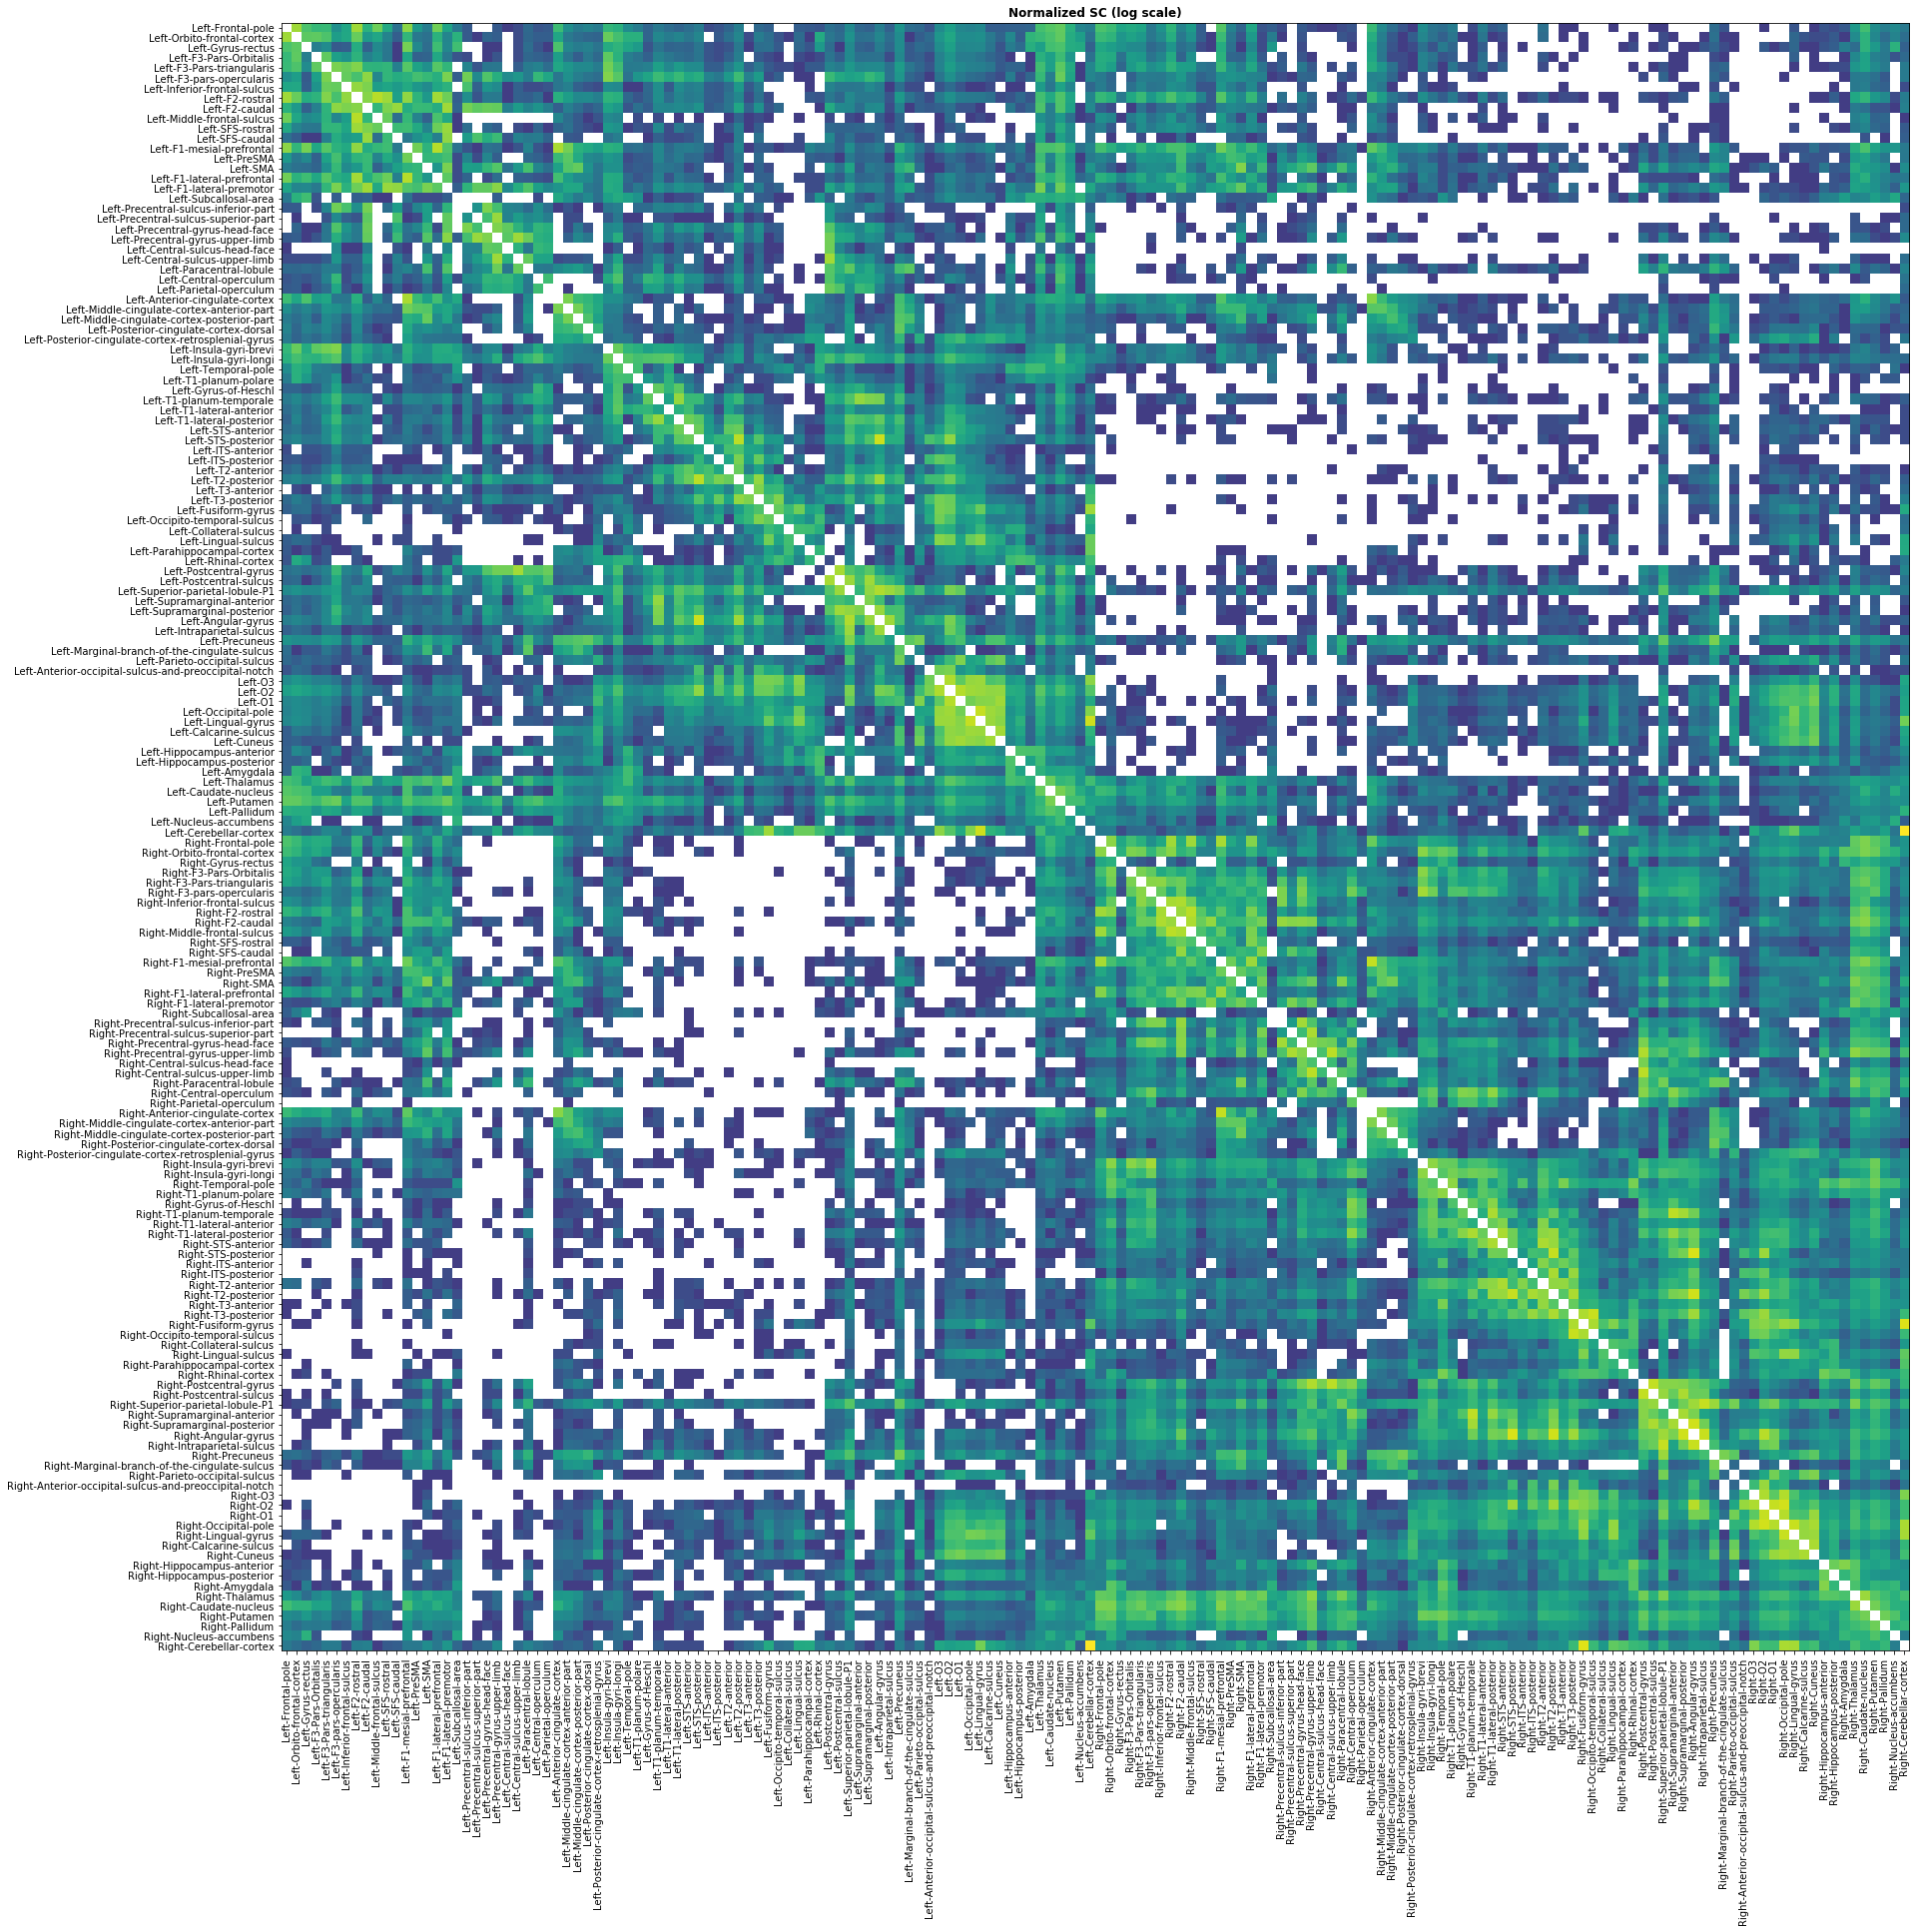

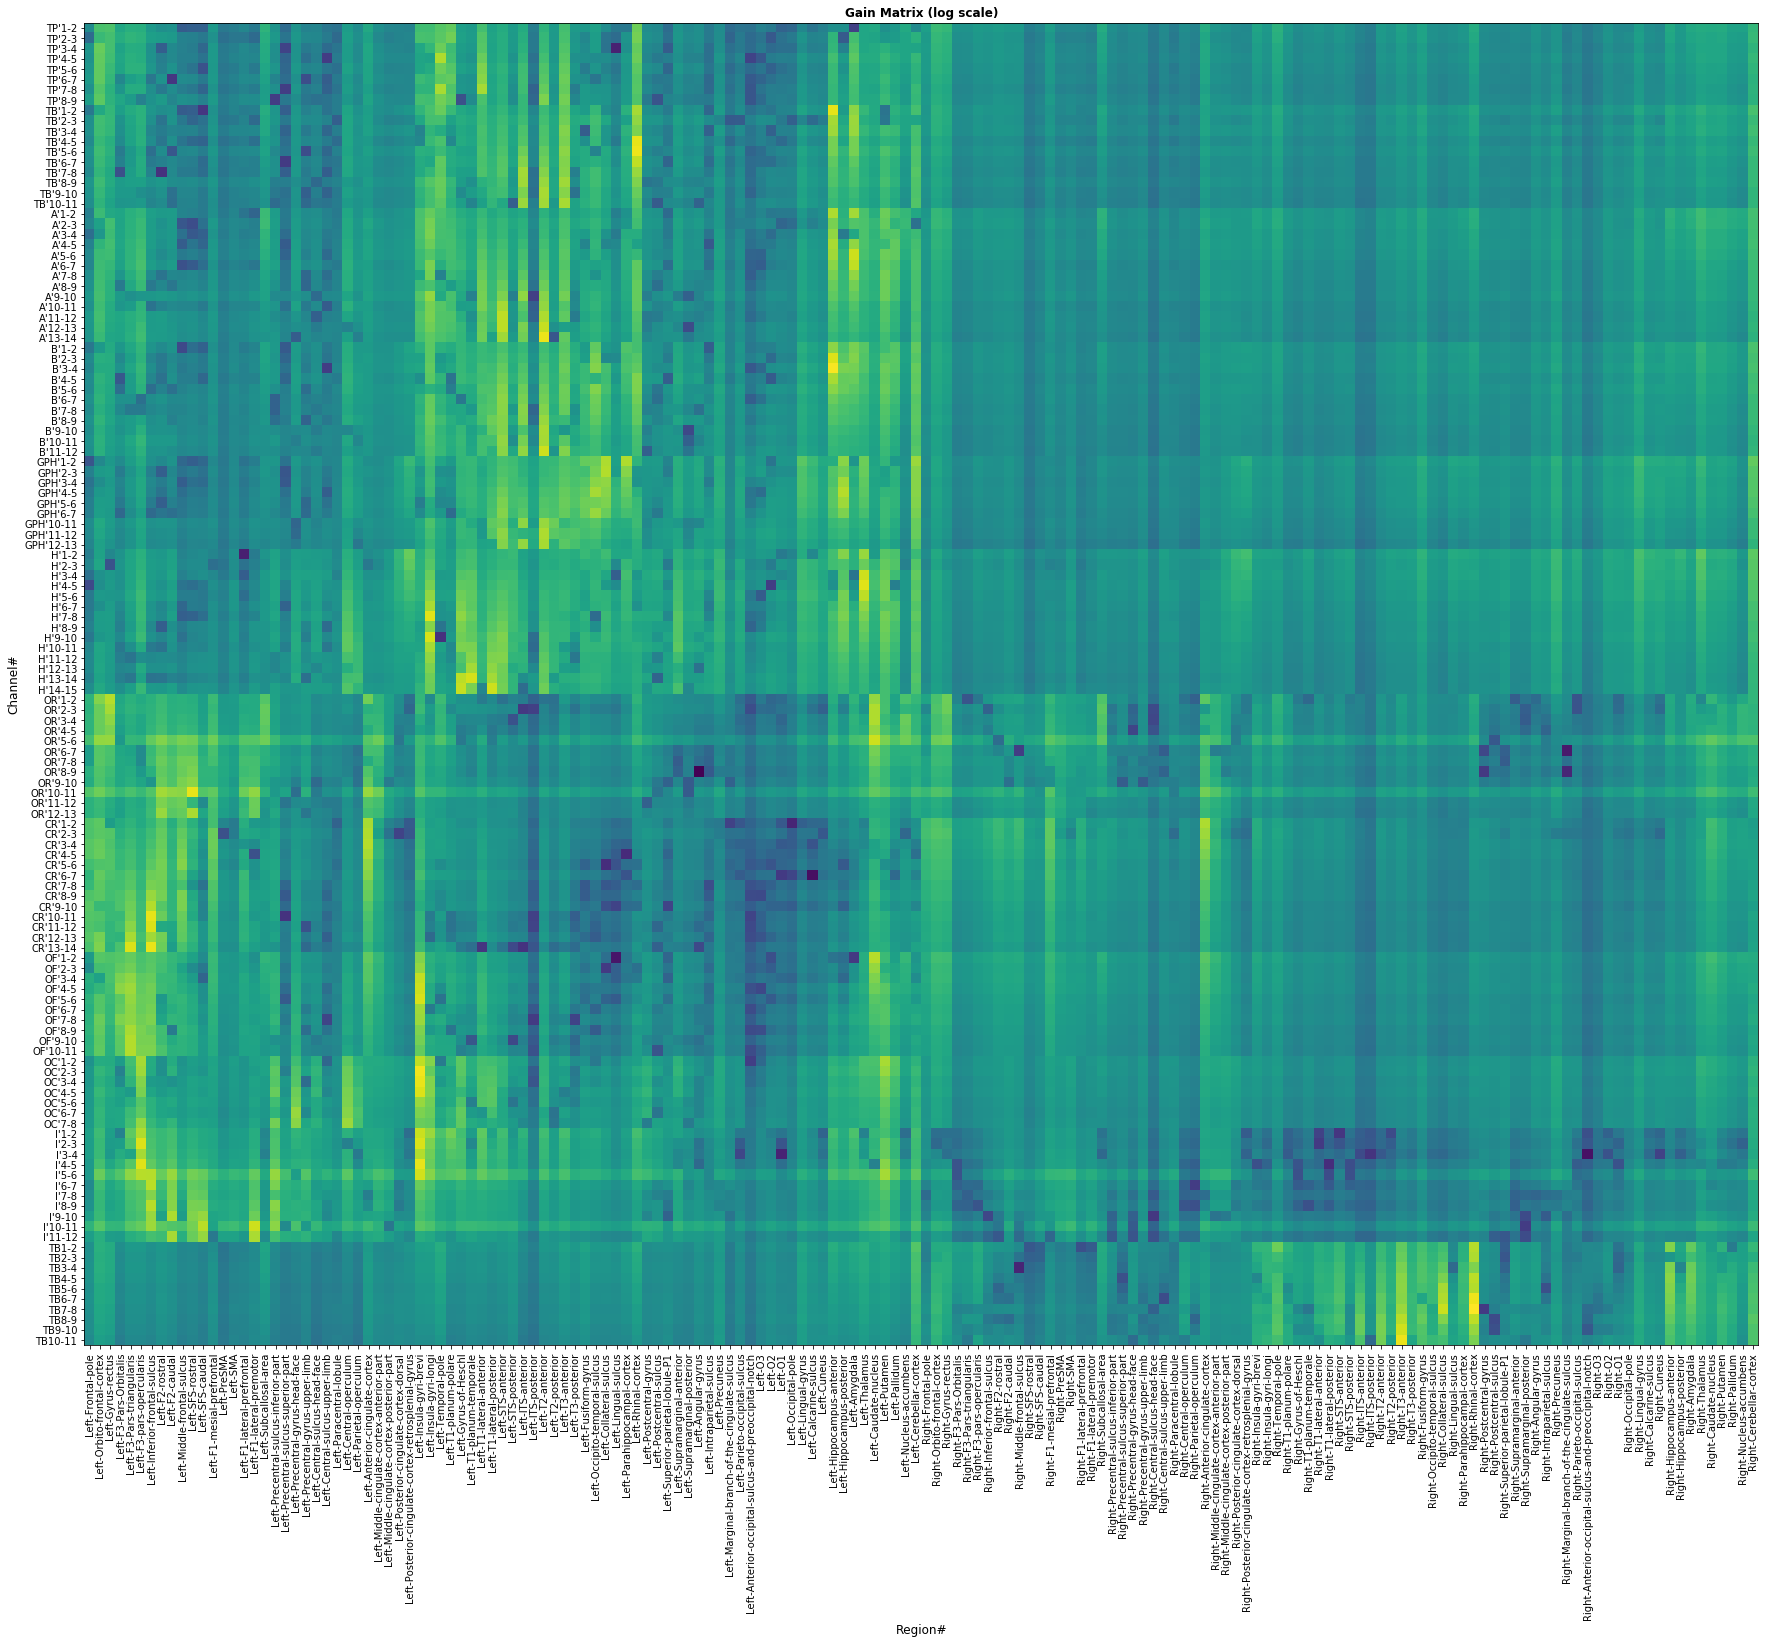

In [11]:
plt.figure(figsize=(30,30))
#plt.subplot(121)
plt.imshow(data['SC'],norm=matplotlib.colors.LogNorm(vmin=1e-6, vmax=data['SC'].max()));
#plt.colorbar(fraction=0.046,pad=0.04);
plt.xticks(np.r_[:len(roi)], roi, rotation = 90);
plt.yticks(np.r_[:len(roi)], roi);
plt.title('Normalized SC (log scale)',fontsize=12, fontweight='bold');
plt.savefig(f'{results_dir}/figures/SC.png')

plt.figure(figsize=(30,30))
#plt.subplot(122)
plt.imshow(data['gain'],norm=matplotlib.colors.LogNorm(vmin=data['gain'].min(), vmax=data['gain'].max()));
#plt.colorbar(fraction=0.046,pad=0.04);
plt.xticks(np.r_[:len(roi)], roi, rotation = 90);
plt.yticks(np.r_[:len(bip.ch_names)], bip.ch_names);
#plt.yticks(np.r_[:len(ei_data['ch_names'])], ei_data['ch_names']);
plt.xlabel('Region#', fontsize=12);
plt.ylabel('Channel#', fontsize=12);
plt.title('Gain Matrix (log scale)',fontsize=12, fontweight='bold');
plt.savefig(f'{results_dir}/figures/gainMatrix.png')

